# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:90% !important; }</style>'))

## Подготовка данных

In [2]:
!pip install catboost

In [3]:
import pandas as pd
import time
import numpy as np
from matplotlib import pyplot as plt
from catboost import CatBoostRegressor, Pool

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

In [4]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/autos/autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')

In [5]:
def df_analyse(data):
    data.info()
    display(data.head(10))
    display(data.describe())
    print(f'размер:    {data.shape}')
    print('пропусков:         ', data.isna().sum().sum())

In [6]:
df_analyse(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


размер:    (354369, 16)
пропусков:          181077


In [7]:
data.columns = data.columns.str.replace(r'([A-Z])', r' \1').str.lower().str.replace(' ', '_').str[1:]

In [8]:
data.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

найдем число уникальных значений в стобце "количество фотографий"

In [9]:
data.number_of_pictures.value_counts()

0    354369
Name: number_of_pictures, dtype: int64

удалим это столбец, и другие неинформативные столбцы: Почтовый код, кол-во фотографий автомобиля, псоледний визит пользоватлея, дата создания карточки, месяц регистрации 

In [10]:
data = data.drop(['number_of_pictures', 'postal_code', 'date_created', 'last_seen', 'registration_month', 'date_crawled'], axis=1)

In [11]:
data.fuel_type.value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fuel_type, dtype: int64

переименуем gasoline в petrol, поскольку оба означают 'бензин' и заполним пропуски значением other.

In [12]:
data['fuel_type'] = data['fuel_type'].replace(['gasoline'],'petrol')
data.fuel_type.fillna('other', inplace=True)

найдем уникальные значения в столбце 'тип кузова'

In [13]:
data.vehicle_type.value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

In [14]:
data.vehicle_type.fillna('other', inplace=True)

найдем уникальные значения стобца 'коробка передач'

In [15]:
data.gearbox.value_counts()

manual    268251
auto       66285
Name: gearbox, dtype: int64

заполним пропуски значением 'unknown'

In [16]:
data.gearbox.fillna('unknown', inplace=True)

в столбце 'модель' и 'была машина в ремонте или нет' тоже заполним пропуски на unknown

In [17]:
data.model.fillna('unknown', inplace=True)
data.repaired.fillna('unknown', inplace=True)

In [18]:
data.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

 найдем уникальные значения в столбце "год регистрации"

In [19]:
data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

поскольку наши данные на 2016 год, удалим все строки с годом после 2016, и, поскольку автомобили до 1900 года это скорее всего аномалии, удалим их тоже

In [20]:
df_years_filtred = data.loc[(data['registration_year'] <= 2016) & (data['registration_year'] >= 1900)]
df_years_filtred['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 1997, 1990, 1981, 2003, 1994, 1991, 1984,
       2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2015,
       1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1970, 1965,
       1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977, 1961, 1960,
       1966, 1975, 1963, 1964, 1954, 1958, 1967, 1959, 1956, 1941, 1962,
       1929, 1957, 1940, 1949, 1937, 1951, 1953, 1933, 1950, 1948, 1952,
       1932, 1942, 1935, 1936, 1923, 1930, 1944, 1943, 1934, 1938, 1928,
       1919, 1931, 1915, 1920, 1947, 1927, 1946])

найдем уникальные значения в столбце 'мощность'

In [21]:
df_years_filtred.power.value_counts()

0       36453
75      22806
60      15169
150     14150
101     12732
        ...  
1704        1
2729        1
1703        1
3750        1
903         1
Name: power, Length: 699, dtype: int64

<AxesSubplot:>

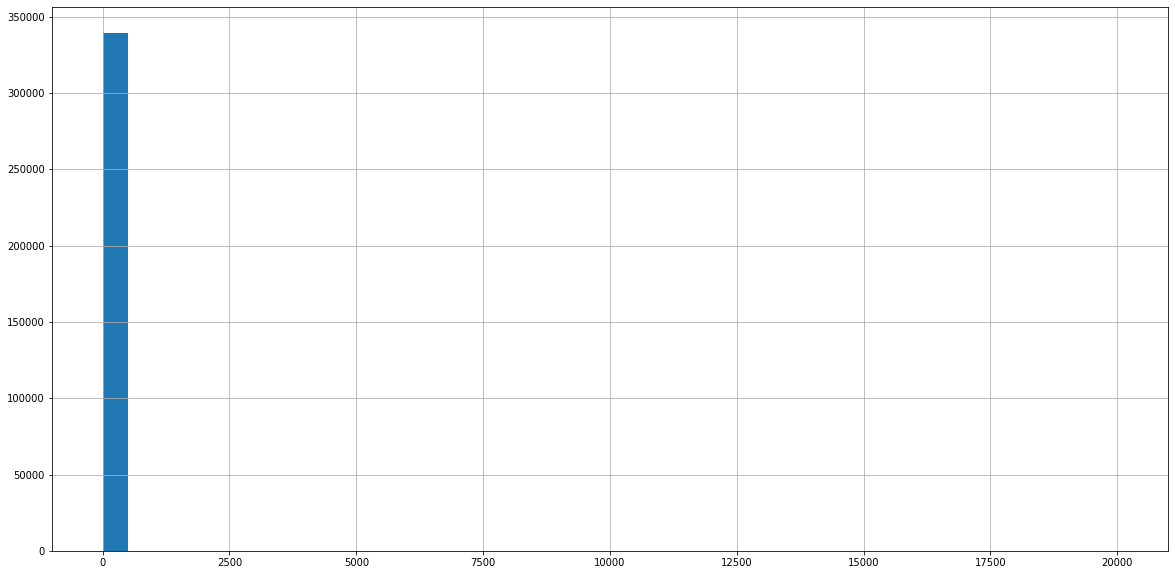

In [22]:
plt.figure(figsize=(20,10))
df_years_filtred['power'].hist(bins = 40)

удалим аномалии - мощность больше 700 лошадиных сил

In [23]:
df_years_filtred = df_years_filtred.loc[df_years_filtred['power'] <= 700]

заменим нули медианой 

In [24]:
df_years_filtred['power'] = df_years_filtred['power'].replace(0, df_years_filtred['power'].median())

<AxesSubplot:>

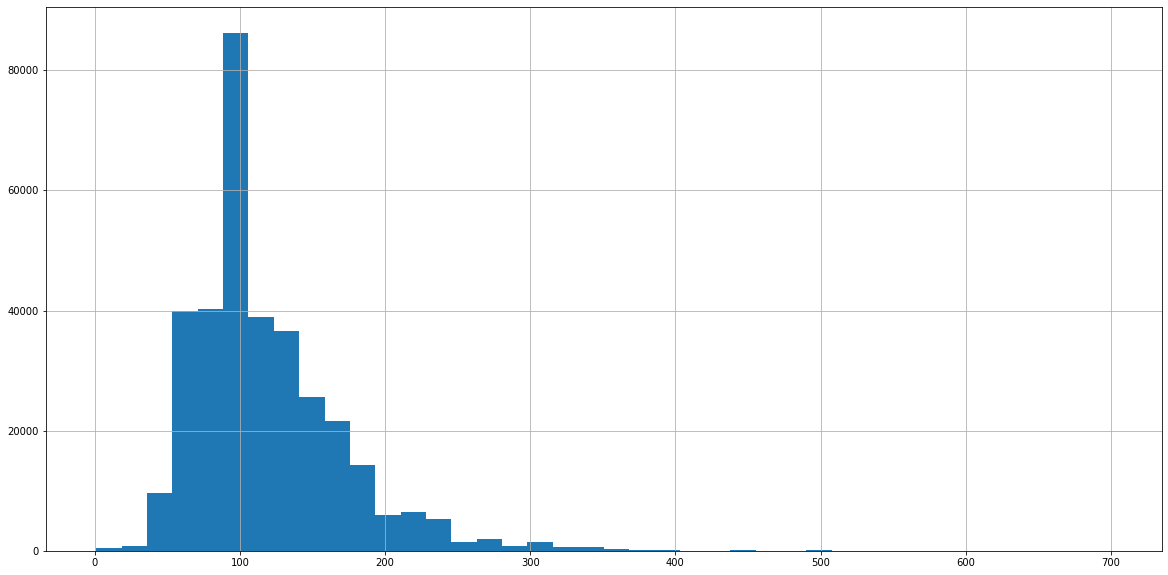

In [25]:
plt.figure(figsize=(20,10))
df_years_filtred['power'].hist(bins = 40)

проверим на аномалии значения столбца "цена"

In [26]:
df_years_filtred['price'].value_counts()

0       9989
500     5461
1500    5082
1000    4359
1200    4328
        ... 
4782       1
6575       1
6208       1
2221       1
8188       1
Name: price, Length: 3693, dtype: int64

<AxesSubplot:>

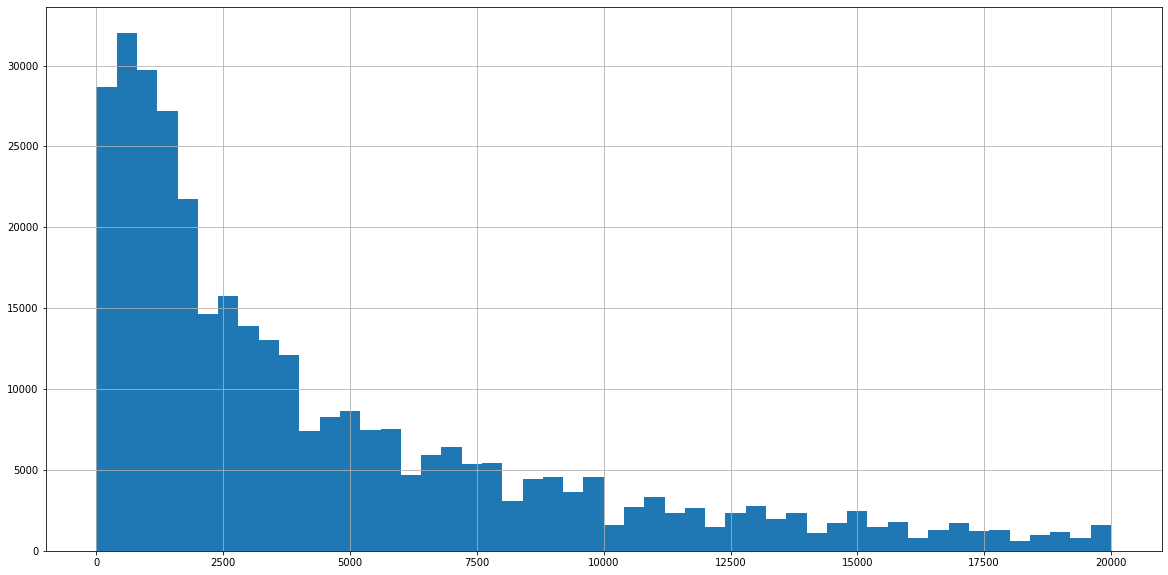

In [27]:
plt.figure(figsize=(20,10))
df_years_filtred['price'].hist(bins = 50)

In [28]:
df_years_filtred= df_years_filtred.loc[df_years_filtred['price']>0]

In [29]:
df_years_filtred['price'].value_counts()

500      5461
1500     5082
1000     4359
1200     4328
2500     4239
         ... 
11897       1
5246        1
6783        1
13949       1
8188        1
Name: price, Length: 3692, dtype: int64

<AxesSubplot:>

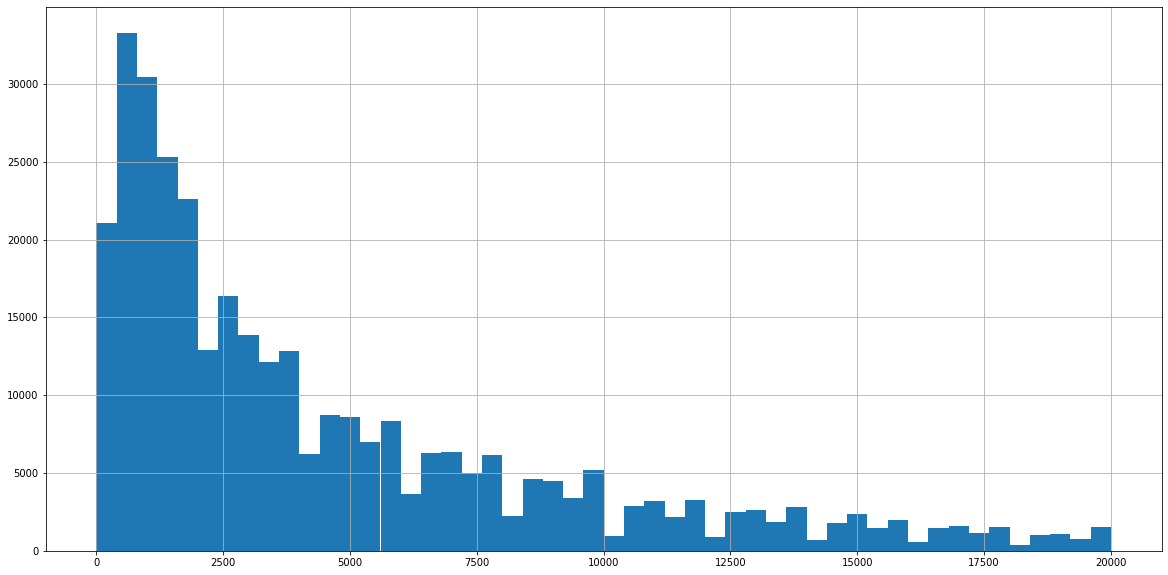

In [30]:
plt.figure(figsize=(20,10))
df_years_filtred['price'].hist(bins = 50)

In [31]:
df_years_filtred.duplicated().sum()

43248

In [32]:
df_years_filtred.duplicated().sum()/len(df_years_filtred)

0.1312681545423917

In [33]:
#удалим дубликаты(с удалением старых индексов и формированием новых)
df = df_years_filtred.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()#проверим

0

### Вывод 
В этом разделе мы произвели предобработку данных. На входе мы получили таблицу с более чем 350 тыс. строк и 16 столбцами. Мы перевели названия столбцов в более удобочитаемый нижний и змеиный регистр, удалили неинформативные столбцы, заполнили пропуски, избавились от аномалий.

## Обучение моделей

In [34]:
#переведем категориальные значения столбцов в количественные
data_ohe = pd.get_dummies(df, drop_first=True)
data_ohe.head()

,price,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
0,480,1993,105.0,150000,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,18300,2011,190.0,125000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004,163.0,125000,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,1500,2001,75.0,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,3600,2008,69.0,90000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
#разделим выборки на обучающую и тестовую
target_ohe = data_ohe['price']
features_ohe = data_ohe.drop('price', axis=1)
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.25, random_state=12345) 
display(features_train_ohe.shape)
display(features_test_ohe.shape)

(214661, 308)

(71554, 308)

In [36]:
numeric = ['power','kilometer']
display(numeric)

['power', 'kilometer']

масштабируем признаки

In [37]:
scaler = StandardScaler()
scaler.fit(features_train_ohe[numeric])
features_train_ohe[numeric] = scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric] = scaler.transform(features_test_ohe[numeric])

In [38]:
features_train_ohe.head()

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
65347,2006,1.043425,0.598993,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3141,2000,-0.575898,0.598993,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
254162,2004,-1.154228,0.598993,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
87782,2014,0.310874,-2.794649,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
191041,2001,-1.154228,0.598993,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


### Линейная регрессия

обучим модель линейной регрессии и произведем замеры

In [39]:
%%time
lr = LinearRegression()
time_fit_start = time.time()
lr.fit(features_train_ohe, target_train_ohe)

CPU times: user 12.8 s, sys: 5.35 s, total: 18.1 s
Wall time: 18.1 s


LinearRegression()

In [40]:
%%time
predictions_train_ohe = lr.predict(features_train_ohe)
print('RMSE:',mean_squared_error(target_train_ohe, predictions_train_ohe, squared=False))

RMSE: 2782.73208974118
CPU times: user 179 ms, sys: 212 ms, total: 391 ms
Wall time: 395 ms


 Обучение и предсказние на тренировчкой выборке дали результаты: обучение 21.7 предсказание длилось 494мс. при этом получили RMSE: 2782.7320897411796

разделим выборки на обучающую и тестовую

In [41]:
target_oe = df['price']
features_oe = df.drop('price', axis=1)

In [42]:
features_train_oe, features_test_oe, target_train_oe, target_test_oe = train_test_split(
    features_oe, target_oe, test_size=0.25, random_state=12345) 

print(features_train_oe.shape)
print(features_test_oe.shape)

(214661, 9)
(71554, 9)


In [43]:
features_train_oe.head()

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
65347,bus,2006,manual,174.0,transporter,150000,petrol,volkswagen,no
3141,wagon,2000,manual,90.0,golf,150000,petrol,volkswagen,no
254162,small,2004,manual,60.0,twingo,150000,petrol,renault,yes
87782,sedan,2014,manual,136.0,1er,20000,petrol,bmw,no
191041,small,2001,manual,60.0,ibiza,150000,petrol,seat,unknown


In [44]:
# закодируем признаки с помощью порядкового кодирования
enc = OrdinalEncoder()
features_train_w_oe =pd.DataFrame(enc.fit_transform(features_train_oe[['vehicle_type','registration_year', 'gearbox', 
            'model','fuel_type',
            'brand', 'repaired']]),columns=['vehicle_type','registration_year', 'gearbox', 
            'model', 'fuel_type',
            'brand', 'repaired'])
features_test_w_oe = pd.DataFrame(enc.fit_transform(features_test_oe[['vehicle_type','registration_year', 'gearbox', 
            'model','fuel_type',
            'brand', 'repaired']]),columns=['vehicle_type','registration_year', 'gearbox', 
            'model', 'fuel_type',
            'brand', 'repaired'])

In [45]:
features_train_w_oe.head()

,vehicle_type,registration_year,gearbox,model,fuel_type,brand,repaired
0,0.0,77.0,1.0,223.0,5.0,38.0,0.0
1,7.0,71.0,1.0,116.0,5.0,38.0,0.0
2,5.0,75.0,1.0,226.0,5.0,27.0,2.0
3,4.0,85.0,1.0,6.0,5.0,2.0,0.0
4,5.0,72.0,1.0,120.0,5.0,30.0,1.0


результаты подбора гипепараметров : max_depth= 20 и n_estimators = 500 показали RMSE 1758.9999144453432 3.5min

Произведем замеры Случаного леса

In [46]:
%%time
rfr = RandomForestRegressor(random_state=12345,n_jobs=-1 ,max_depth=20, n_estimators=500)
rfr.fit(features_train_w_oe, target_train_oe)

CPU times: user 2min 14s, sys: 1.62 s, total: 2min 16s
Wall time: 2min 16s


RandomForestRegressor(max_depth=20, n_estimators=500, n_jobs=-1,
                      random_state=12345)

In [47]:
%%time
rfr_predicted = rfr.predict(features_train_w_oe)
print(mean_squared_error(target_train_oe,rfr_predicted,squared=False))

1619.6435702116605
CPU times: user 23.7 s, sys: 39.3 ms, total: 23.7 s
Wall time: 23.8 s


На тренировочной выборке случайный лес показал скорость обучения 4минут 8с а предсказание длилось 31.7с , RMSE при этом 1068.1959113577552

### LightGBM

In [48]:
# выделим признаки и целевой признак
target = df['price']
features = df.drop('price', axis=1)

# переведем категориальные признаки в тип category, который требуется для LightGBM
for c in features.columns:
    col_type = features[c].dtype
    if col_type == 'object':
        features[c] = features[c].astype('category')

#разделим выборки на обучающую и тестовую
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345) 

# проверим размер выборок
print(features_train.shape)
print(features_test.shape)

(214661, 9)
(71554, 9)


In [49]:
#Эти параметры я оставил для наглядности. Подбор уж очень долго происходит
lgbm_param_grid = {'n_estimators':  [500], 'num_leaves': [n for n in range (120, 140, 20)]}

In [50]:
lgbm= lgb.LGBMRegressor(random_state=12345)

gs_lgbm=GridSearchCV(estimator=lgbm,
                          param_grid=lgbm_param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=3,
                          verbose=3)

gs_lgbm.fit(features_train, target_train, categorical_feature =["vehicle_type","gearbox",
                                                             "model","fuel_type",
                                                             "brand","repaired"])
display(gs_lgbm.best_params_)
display(gs_lgbm.best_score_*-1)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END ...............n_estimators=500, num_leaves=120; total time=  34.7s
[CV 2/3] END ...............n_estimators=500, num_leaves=120; total time=  44.0s
[CV 3/3] END ...............n_estimators=500, num_leaves=120; total time=  40.8s


{'n_estimators': 500, 'num_leaves': 120}

1645.5473577173623

Лучшие парметры для этой модели n_estimators= 500 и num_leaves = 120
RMSE 1659.3915019631042

In [51]:
%%time
lgbm = lgb.LGBMRegressor(random_state=12345, n_estimators= 500, num_leaves = 120)
lgbm.fit(features_train, target_train,  categorical_feature =["vehicle_type","gearbox",
                                                             "model","fuel_type",
                                                             "brand","repaired"])

CPU times: user 37.2 s, sys: 794 ms, total: 38 s
Wall time: 38.2 s


LGBMRegressor(n_estimators=500, num_leaves=120, random_state=12345)

In [52]:
%%time
lgbm_predicted = lgbm.predict(features_train)
print(mean_squared_error(target_train,lgbm_predicted,squared=False))

1337.3506373634418
CPU times: user 19 s, sys: 43.7 ms, total: 19 s
Wall time: 19 s


На тренировочной выборке LGBM показал скорость обучения 15.9с, а предсказание длилось 20.2с , RMSE при этом 1336.8322918623821

### CatBoost

In [53]:
#Эти параметры я оставил для наглядности. Подбор уж люто долго происходит
cbr_param_grid = {'depth':[10],'learning_rate':np.arange(0.1,0.3,0.2)}

In [54]:
cbr= CatBoostRegressor(loss_function='RMSE',random_state=12345)
gs_cbr= GridSearchCV(estimator=cbr,
                          param_grid=cbr_param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=3,
                          verbose=3)

gs_cbr.fit(features_train, target_train,cat_features=["vehicle_type","gearbox",
                                                             "model","fuel_type",
                                                             "brand","repaired"])
display(gs_cbr.best_params_)
display(gs_cbr.best_score_*-1)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
0:	learn: 4282.1238247	total: 382ms	remaining: 6m 22s
1:	learn: 3988.8362806	total: 677ms	remaining: 5m 37s
2:	learn: 3738.0929966	total: 993ms	remaining: 5m 30s
3:	learn: 3512.5122351	total: 1.31s	remaining: 5m 26s
4:	learn: 3313.4484840	total: 1.61s	remaining: 5m 20s
5:	learn: 3144.1473474	total: 1.92s	remaining: 5m 17s
6:	learn: 2988.1370243	total: 2.22s	remaining: 5m 14s
7:	learn: 2846.8034668	total: 2.56s	remaining: 5m 17s
8:	learn: 2725.1408432	total: 2.85s	remaining: 5m 13s
9:	learn: 2617.8955433	total: 3.15s	remaining: 5m 12s
10:	learn: 2525.3474362	total: 3.46s	remaining: 5m 11s
11:	learn: 2445.3536837	total: 3.83s	remaining: 5m 15s
12:	learn: 2374.3360556	total: 4.2s	remaining: 5m 18s
13:	learn: 2312.7986143	total: 4.6s	remaining: 5m 23s
14:	learn: 2260.1496305	total: 4.9s	remaining: 5m 21s
15:	learn: 2215.6843116	total: 5.33s	remaining: 5m 27s
16:	learn: 2166.1712494	total: 5.67s	remaining: 5m 27s
17:	learn: 2126.418

KeyboardInterrupt: 

{'depth': 10, 'learning_rate': 0.1}
1658.4499129859653

In [ ]:
%%time
cbr = CatBoostRegressor(loss_function='RMSE',random_state=12345, depth=10, learning_rate=0.1)
cbr.fit(features_train, target_train,cat_features=["vehicle_type","gearbox",
                                                             "model","fuel_type",
                                                             "brand","repaired"])

In [1]:
%time
cbr_predicted = cbr.predict(features_train_oe)
print(mean_squared_error(target_train_oe,lgbm_predicted,squared=False))

CPU times: total: 0 ns
Wall time: 0 ns


NameError: name 'cbr' is not defined

На тренировочной выборке CatBoost показала скорость оубчения 2мин 6с, RMSE при этом 1336.8322918623821

## Анализ моделей

In [ ]:
tabledata = [['линейная регрессия','21.7 s', '494 ms', '2779'],
        ['случайный лес', '7m 20s', '50.2 s','1068'],
        ['LightGBM','15 s', '20.2 s', '1336'],
        ['CatBoost','2m 6s', '7ms', '1336']]
df= pd.DataFrame(tabledata, columns=['модель','Время обучения','Время предсказания', 'RMSE'])
df = df.set_index('модель')
df.index.names = [None]
df

Согласно результатов тестов: LightGBM показала одинаковый RMSE с CatBoost, но скорость обучения у LightGBM оказалсь быстрее чем у CatBoost  Поверим на тестовой выборке модель LightGBM

In [ ]:
%%time
lgbm = lgb.LGBMRegressor(random_state=12345,
                          n_estimators=500,
                          num_leaves=120)
lgbm.fit(features_train, target_train,categorical_feature =["vehicle_type","gearbox",
                                                             "model","fuel_type",
                                                             "brand","repaired"])

In [ ]:
%%time
lgbm_predicted = lgbm.predict(features_test)
print(mean_squared_error(target_test, lgbm_predicted ,squared=False))

In [ ]:
x_ax = range(len(target_test))
plt.figure(figsize=(20, 10))
plt.plot(x_ax, target_test, label='original')
plt.plot(x_ax, lgbm_predicted, label='Предсказание LightGBM')
plt.title('Определение стоимости автомобилей: тестовые и предсказанные данные')
plt.xlabel('features')
plt.ylabel('Price')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()  

На граффике выше изображена различия предсказания цены моделью от цены из датасета

## Вывод


В даной работе мы перевели названия столбцов в более удобочитаемый нижний и змеиный регистр, удалили неинформативные столбцы, заполнили пропуски, избавились от аномалий. Удалили дубликаты.

Мы обучили разные модели, подобрали гиперпараметры для них и обнаружили что  модель LightGBM с гиперпараметрами 'n_estimators'= 500, 'num_leaves'= 120 на тренировочной выборке выдает наименьшее значение RMSE 1336

Мы проанализировали модели и обнаружили, что дольше всего учится модель случайного леса: 4m 8s 	,а меньше всего училась линейная регрессия но результат ее пердсказания относительно других моделей низок.Самую высокую точность  пердсказания показали модель Случайный лес.  Модель LightGBM имеет приемлемую скорость обучения (в пределах 40 сек.) и при этом RMSE на относительно низком уровне из всех моделей: на тестовой выборке результат 1621.

Исходя из требований заказчика по скорости обучения, придсказания и качества модели, рекомендуем модель LightGBM, поскольку она имеет самые оптимальные характеристики

